# Containerised Jupyter Notebook Access from Docker Container

## Introduction

In [1]:
print('Hello world from Dockerised AMICI')

Hello world from Dockerised AMICI


In [2]:
import os 
path = os.getcwd()
print('Current working directory:', path)

# change the working directory to '/\new-peak-project'

os.chdir('/new-peak-project/src')
print('Changed working directory to:', os.getcwd())

Current working directory: /app
Changed working directory to: /new-peak-project/src


In [3]:
# set the results directory to '/new-peak-project/src/experiments'

results_path = '/new-peak-project/src/experiments'

In [4]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

import amici

In [6]:
import os 

### parameters 
notebook_name = 'generate_large_model'
sub_id = '1'

## Generation of ground truth model 
model_name = 'v3_small_model_52'
o_random_seed = 6 
parameter_random_seed = 6
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 
simulation_time = 500 
simulation_step = 100

## Feature data generation 
feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 
'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 
data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + sub_id
experiment_folder = results_path + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang'
os.environ['AMICI_EXTRACT_CSE'] = '1'
# os.environ['AMICI_IMPORT_NPROCS'] = '6'
# os.environ['AMICI_PARALLEL_COMPILE'] = '6'

/new-peak-project/src/experiments/generate_large_model_1/


In [7]:
### Generate the ground truth model
seed = 4
parameter_random_seed = 4
num_species = 500
num_feedback = 250
model_name = f'example_model_{seed}_{parameter_random_seed}_{num_species}_{num_feedback}'

model_spec = ModelSpecification()
model_spec.generate_specifications(seed, num_species, num_feedback, verbose=0)
# G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)
# runner = roadrunner.RoadRunner(G0.get_sbml_model())

In [8]:
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)

In [9]:
print(G0)

Model Name example_model_4_4_500_250
Number of Reactions 2002
Number of State Variables 2002
Number of Parameters 5254
Number of Custom Variables 0
Number of Enforced State Values 0
Number of Custom Strings 0



In [10]:
# save the sbml model to the results folder
sbml_file = experiment_folder + model_name + '.xml'
with open(sbml_file, 'w') as f:
    f.write(G0.get_sbml_model())
print('SBML model saved to:', sbml_file)

SBML model saved to: /new-peak-project/src/experiments/generate_large_model_1/example_model_4_4_500_250.xml


## Use AMICI to simulate model

In [11]:
import amici

sbml_importer = amici.SbmlImporter(f"/new-peak-project/src/experiments/generate_large_model_1/{model_name}.xml")

In [12]:
import logging
model_dir = "model_dir"
sbml_importer.sbml2amici(model_name, model_dir, verbose=logging.INFO, generate_sensitivity_code=False, constant_parameters=False, simplify=None)

2025-04-30 09:54:52.932 - amici.sbml_import - INFO - Finished importing SBML                         (1.66E+01s)
2025-04-30 09:54:57.597 - amici.sbml_import - INFO - Finished processing SBML observables            (4.64E+00s)
2025-04-30 09:54:57.603 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.84E-06s)
2025-04-30 09:55:16.189 - amici.de_model - INFO - Finished computing xdot                            (4.23E-03s)
2025-04-30 09:55:16.221 - amici.de_model - INFO - Finished computing x0                              (3.78E-03s)
2025-04-30 09:55:16.240 - amici.de_model - INFO - Finished computing w                               (3.48E-03s)
2025-04-30 10:02:11.041 - amici.de_export - INFO - Finished generating cpp code                      (4.39E+02s)
2025-04-30 10:03:26.043 - amici.de_export - INFO - Finished compiling cpp code                       (8.03E+01s)


In [13]:
model_dir = "model_dir"
# load the model module
model_module = amici.import_model_module(model_name, model_dir)
# instantiate model
model = model_module.getModel()
# instantiate solver
solver = model.getSolver()

In [14]:
solver.setAbsoluteTolerance(1e-10)

In [15]:
# Create Model instance
model = model_module.getModel()

# set timepoints for which we want to simulate the model
model.setTimepoints(np.linspace(0, 500, 500))

# Create solver instance
solver = model.getSolver()

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

In [16]:
print(
    "Simulation was run using model default parameters as specified in the SBML model:"
)
print(dict(zip(model.getParameterIds(), model.getParameters())))

Simulation was run using model default parameters as specified in the SBML model:
{'J0_Vmax': 109.83616177738, 'J0_Km': 994.773880742686, 'J1_Vmax': 0.137716909709473, 'J1_Kw0': 0.5142750718556, 'J1_Km': 287.919483927338, 'J2_Vmax': 78.5186529992417, 'J2_Km': 250.510640113985, 'J3_Vmax': 29.7452056544061, 'J3_Km': 868.774052034755, 'J4_Vmax': 6.25678153880696, 'J4_Km': 578.345752247965, 'J5_Vmax': 48.4261930674184, 'J5_Km': 135.162559793197, 'J6_Vmax': 67.2467917313973, 'J6_Km': 695.612627432444, 'J7_Vmax': 19.5495887423345, 'J7_Km': 193.611338866504, 'J8_Vmax': 23.0036062540216, 'J8_Km': 168.070523672205, 'J9_Vmax': 17.3210022979593, 'J9_Km': 728.383313294636, 'J10_Vmax': 26.9719963222366, 'J10_Km': 564.348720188279, 'J11_Vmax': 5.22478186633009, 'J11_Km': 822.771301667924, 'J11_Kic0': 0.407013221546125, 'J12_Vmax': 79.0346633834236, 'J12_Km': 881.597749902017, 'J13_Vmax': 46.226034435179, 'J13_Km': 450.879753304262, 'J14_Vmax': 50.3257070037513, 'J14_Km': 823.989504876327, 'J15_Vmax'

In [17]:
time_points = rdata.ts
res = rdata.x.T
res_states = model.getStateNames()

In [18]:
print(res.shape)

(2002, 500)


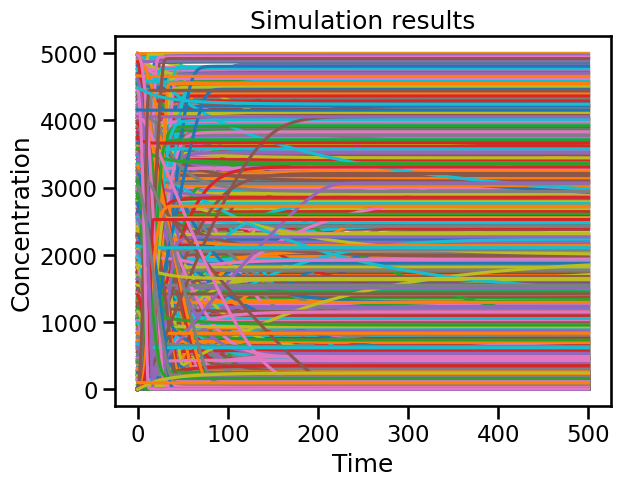

In [19]:
# use matplotlib to plot the results of each res 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.axes_style('whitegrid')

for i in range(res.shape[0]):
    plt.plot(time_points, res[i,:], label=res_states[i])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation results')
plt.show()

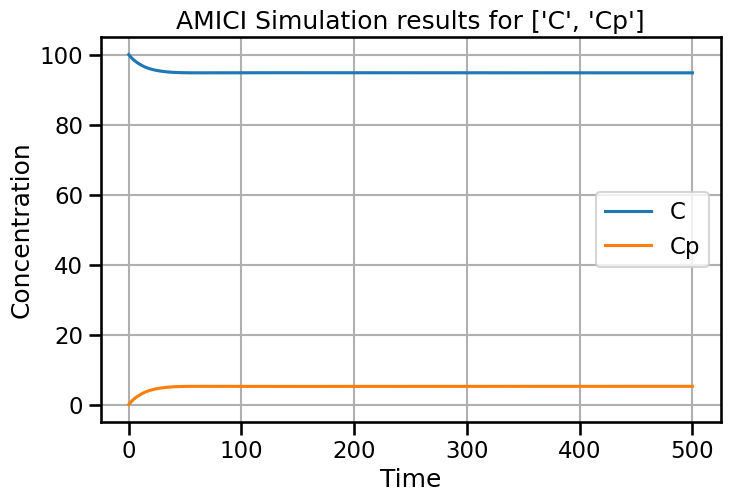

In [20]:
# only plot C and Cp 

states_plot = ['C', 'Cp']
states_plot_index = {}
for state in states_plot:
    for i in range(len(res_states)):
        if state == res_states[i]:
            states_plot_index[state] = i
            break
        
plt.figure(figsize=(8, 5))
for state in states_plot:
    plt.plot(time_points, res[states_plot_index[state],:], label=state)
    
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('AMICI Simulation results for ' + str(states_plot))
plt.legend()
plt.grid()
plt.show()